# 1) Introduction

This notebooks presents a solution to the Kaggle data science competition: 'Titanic: Machine Learning from Disaster'. The notebook trains a logistic classifier and uses ensemble methods to predict whether passengers in a test set of data survived the sinking of the Titanic. The final solution achieves an accuracy of X% and is ranked in the top 100 on Kaggle.


# 2) Data Exploration

In [0]:
#Load in libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#Load in data
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [0]:
#Check the dataframe 
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
#Check the data types in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [0]:
#Check the distribution of numerical values in the dataframe
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [0]:
#check categorical data columns
print(df['Embarked'].value_counts())
print(df['Sex'].value_counts())
print(df['SibSp'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


**Observations/conclusions**

The dataset consists of 12 features including numerical, string and categorical data:
*   **Passenger ID:** A unique integer identifies each passeneger on board the Titanic.
*   **Survived:** A categorical integer of 1 or 0 indicates whether the passenger survived or died respectively.
*   **Pclass:** A categorical integer of 1, 2 or 3 indicates passenger's class of travel (>50% were in class 3)
*   **Name:** A string records details of the passenger's name including title if known.
*   **Sex**: A categorical string of male or female indicates the passgener's gender.
*   **Age**: An integer represents the passeneger's age in years (range is from 1 to 80 and the median is 28)
*   **Sibsp:** An integer records the number of siblings the passenger had on board (median is 0, max is 8)
*   **Parch:** An integer records number of parents/children passenger had on board (range is 0-6)
*   **Ticket:** An object records ticket ID. It is difficult to discern a pattern in this data.
*   **Fare:** A float indicates the fare paid. The distribution is skewed (range 0-512, mean = 32, median = 14)
*   **Cabin:** An object records cabin of travel. Object starts with a strong indicating position on board. 
*   **Embarked:**A categorical string of S, C or Q indicates hwere passengers embarked. 















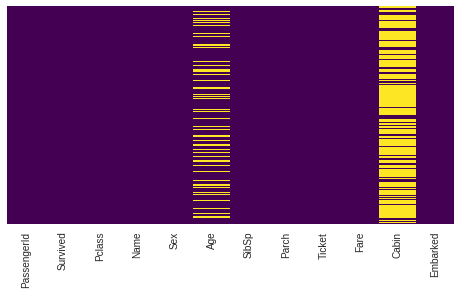

In [0]:
#Check data gaps
fig, ax = plt.subplots(figsize=(8,4))
g = sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis', ax = ax)

The figure shows that only the age and cabin columns have data gaps. These will be addressed using the inisghts from the feature anaysis in the next section.

# 3) Feature Analysis 

## 3.1) Numerical Values

In [0]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

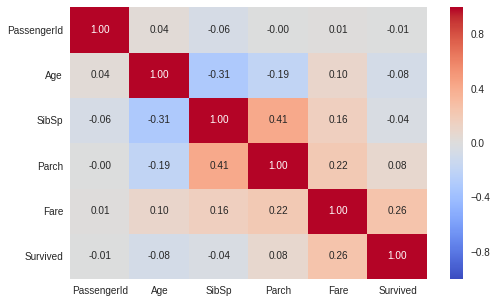

In [0]:
#Vizualise relationship between numerical values
fig, ax = plt.subplots(figsize=(8,5))
g = sns.heatmap(df[['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(), annot = True, fmt=".2f", cmap="coolwarm")

The figure shows the Pearsons Correlation Coefficient (PCC) for numerical values in the dataset. The PCC take values from -1 to +1. A PCC of 1 or -1 indicates a perfect positive or negative linear correlation between two variables respectively. A score of 0 represents no correlation. The figure shows that Fare is most correlated with survival outcome. This suggests that they will be important features for the model. However, this does not mean the other features are not useful as subpopulations of these features could be correlated with survival. To determine this we need to explore these features in detail.

**No. of sibling onboard (SibSp)**

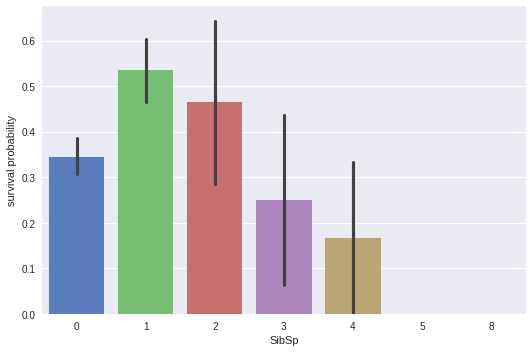

In [0]:
g  = sns.factorplot(x="SibSp",y="Survived",data=df,kind="bar", size = 5, aspect=1.5, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The figure shows that there was a statistically significant higher survival probability for passengers that had 1 sibling on board. While, it looks as though having 3 or more siblings on board led to lower survival probability, care should be taken as these categories are small samples which have large standard deviations. Despite this, the results of the analysis suggest that SibSp should be included in features for the machine learning model. 

**Number of parents/children on board (Parch)**

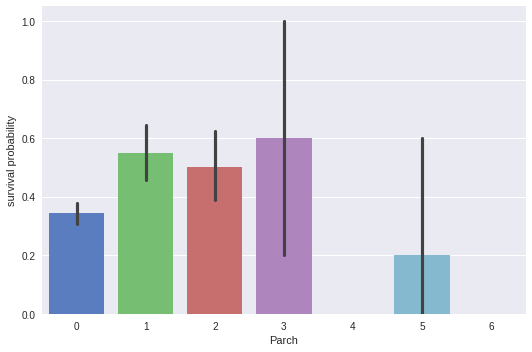

In [0]:
g  = sns.factorplot(x="Parch",y="Survived",data=df,kind="bar", size = 5, aspect=1.5, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The figure shows that families that had 1, 2 or 3 parents/children on board had a higher survival probability. Larger familes had lower survival probabilties, although thered there is a large standard deviation so care should be taken with this observation. An interpretation of the data is that although families may have been evacuated first, larger families may have struggled to find members during the disaster and may have also struggled to fit onto lifeboats due to space limitations. 



**Age**

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


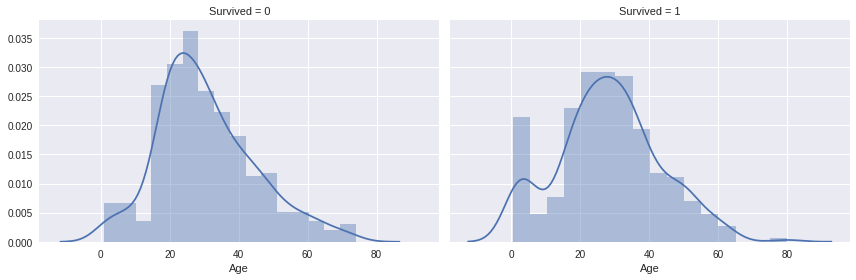

In [0]:
g = sns.FacetGrid(data = df, col = 'Survived', size = 4, aspect = 1.5)
g.map(sns.distplot, "Age")

The figure shows the relationship between age and survival outcome. It appears to be a tailed distribution, possibly a gaussian. The left hand panel shows the age distribution of passengers which died and the right hand panel shows the age distribution of passengers which survived. It it notable that there are some age categories which appear to have had higher survival rates. For example, passenegrs in the age range 0-10 have a relatively high survival rate (shown by the peak on the RHS) and passenfers over the age of 60 were more likely to have died.  This insight matches up with the fact that the young were evacuated first.


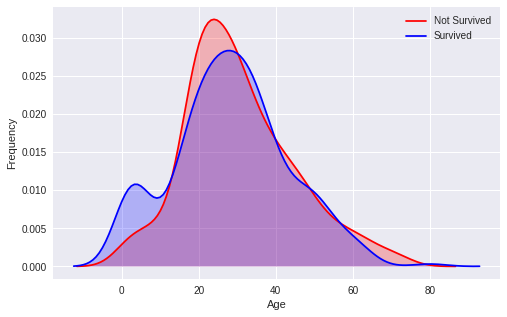

In [0]:
# Explore Age distibution by plotting overlapping kde plots
fig, ax = plt.subplots(figsize=(8,5))
g = sns.kdeplot(df["Age"][(df["Survived"] == 0) & (df["Age"].notnull())], ax = ax, color="Red", shade = True)
g = sns.kdeplot(df["Age"][(df["Survived"] == 1) & (df["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

When the plots are superimposed it is clear that age groups had different survival rates. In the figure blue regions indicate survival rates >50% (e.g. age 0-10 year) and red regions indicate survival rates <50% (e.g. age 10-30 and 60-80 years). 

**Fare**

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


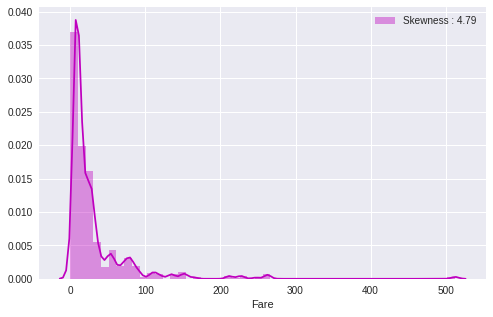

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.distplot(df["Fare"], color="m", label="Skewness : %.2f"%(df["Fare"].skew()), ax = ax)
g = g.legend(loc="best")

The figure shows that fare paid by passengers was a skewed distribution raning from 0-500 with a skweness of 4.79. In gerneral, if skweness is less than -1 or greater than 1, the data can be considered to be highly skewed. As this can lead to overweighing the influence of extreme values in the model (even with scaling), we will perform a log transformation to reduce the skew of the distribution. 


In [0]:
#Apply log transformation 
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


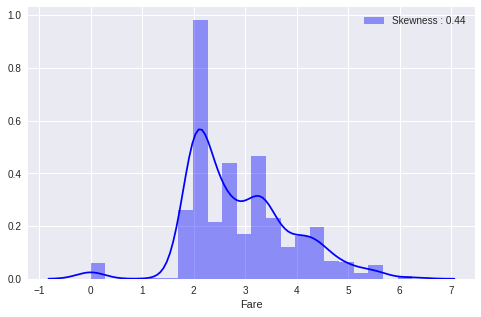

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.distplot(df["Fare"], color="b", label="Skewness : %.2f"%(df["Fare"].skew()), ax = ax)
g = g.legend(loc="best")

Te figure shows that skew is clearly reduced after the transformation.

## 3.2) Categorical Values

**Sex**

In [0]:
df[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


The table shows that 74% of females on board the Titanic survived compared to 19% of males.

**PClass**

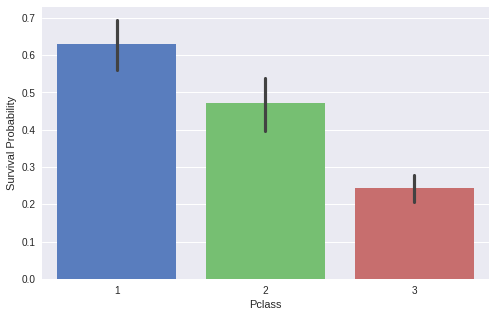

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.barplot(x="Pclass",y="Survived",data=df, palette = "muted", ax = ax)
g = g.set_ylabel("Survival Probability")

Passengers in higher classes were more likely to survive. For example, passengers in first class were more than twice as likely to survive as passenegers in third class. This will be an important feture in the model. But, how did class correlate with sex and age whiich we also know are improtant features? 

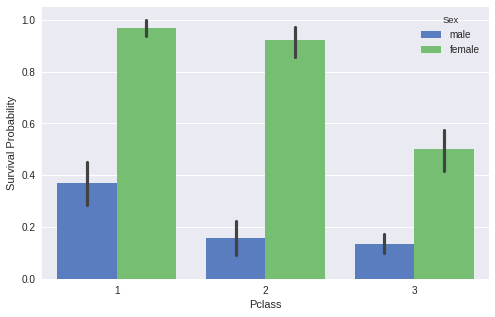

In [0]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.barplot(x="Pclass",y="Survived", hue = 'Sex', data=df, palette = "muted", ax = ax)
g = g.set_ylabel("Survival Probability")

The figure shows that women in all classes were more likely to survie than males Howevre, it is particualrly, striking that females in higher classess were much more liekly to survive than in lwoer classes. Therefore, it seems sex and Pclass travel will both be important features for the model. 

In [0]:
#Group ages and explore survival by class and age

**Embarked**

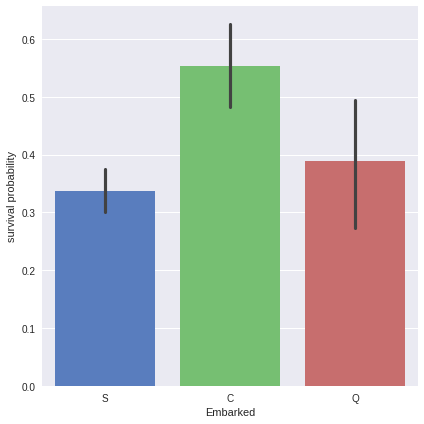

In [0]:
g = sns.factorplot(x="Embarked", y="Survived",  data=df, size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

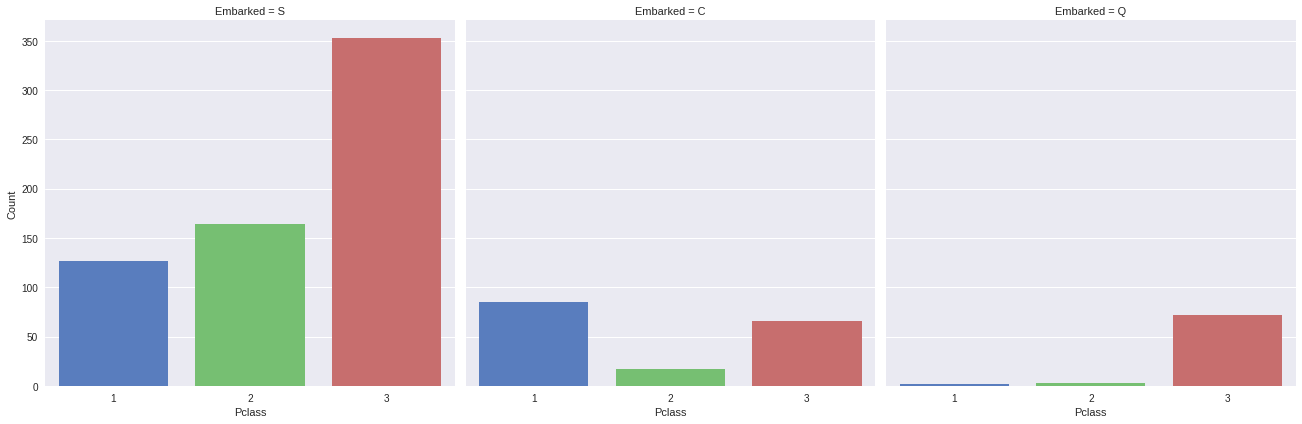

In [0]:
g = sns.factorplot("Pclass", col="Embarked",  data=df,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

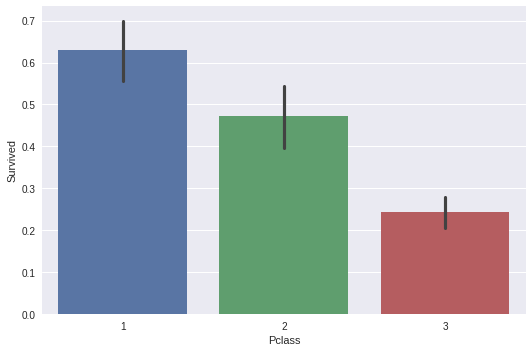

In [0]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', data = df, kind = "bar", size = 5, aspect = 1.5)

# Data Wrangling

# Model Selection